# 1. Import Dependencies and Data

In [1]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      1.4.0
anyio                        4.3.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.3.3
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
dm-tree                      0.1.8
etils                        1.7.0

In [2]:
!nvidia-smi

Fri Mar 29 16:52:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   39C    P8              12W / 136W |    101MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU(s) available:", gpus)
else:
    print("No GPU(s) available")

GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!pip install tensorflow-datasets matplotlib Pillow

In [5]:
# Bringing in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [6]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

# 2. Viz Data and Build Dataset

In [7]:
# Do some data transformation
import numpy as np

In [8]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [9]:
# Getting data out of the pipeline
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

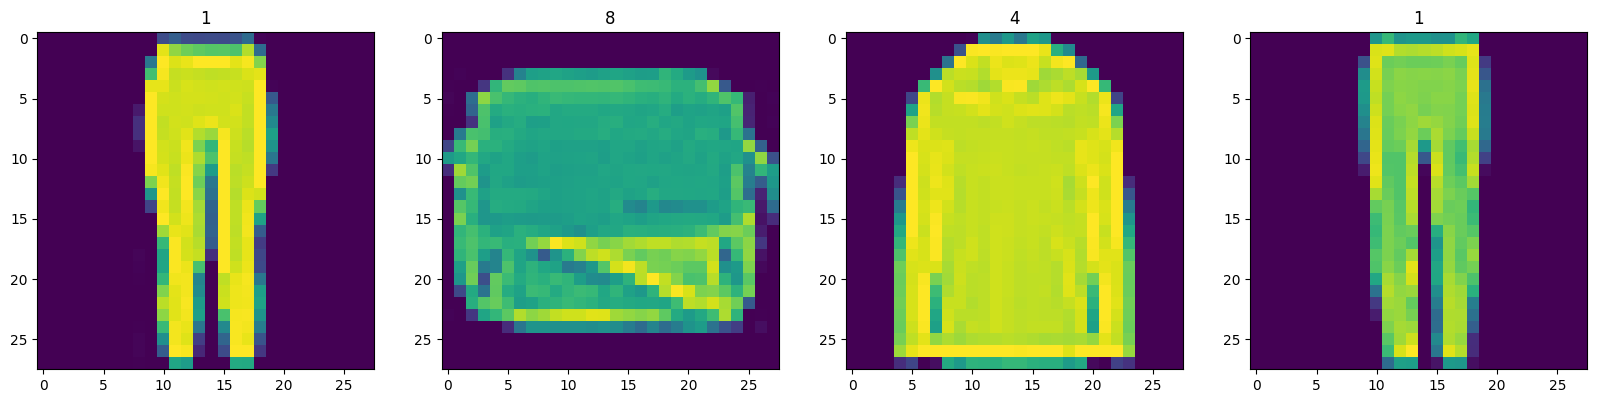

In [10]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    batch = dataiterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(batch['image']))
    # Appending the image label as the plot title
    ax[idx].title.set_text(batch['label'])

In [11]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [12]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottleneckinng
ds = ds.prefetch(64)

In [13]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

## 3.1 Import Modelling Components

In [14]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## 3.2 Build Generator

In [15]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [16]:
generator = build_generator()

In [17]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [18]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
img

1/1 [==============================] - 3s 3s/step


array([[[[0.5003914 ],
         [0.49833348],
         [0.49569565],
         ...,
         [0.50189126],
         [0.5017605 ],
         [0.49572167]],

        [[0.51221573],
         [0.51314   ],
         [0.50655866],
         ...,
         [0.5095344 ],
         [0.49879068],
         [0.49631107]],

        [[0.5107604 ],
         [0.50495756],
         [0.5110172 ],
         ...,
         [0.500719  ],
         [0.49905953],
         [0.4966101 ]],

        ...,

        [[0.5010985 ],
         [0.50632644],
         [0.5088181 ],
         ...,
         [0.5089488 ],
         [0.50410235],
         [0.5019612 ]],

        [[0.50001574],
         [0.51033354],
         [0.51332015],
         ...,
         [0.5100001 ],
         [0.5066968 ],
         [0.50401706]],

        [[0.49877253],
         [0.5010237 ],
         [0.5034039 ],
         ...,
         [0.505658  ],
         [0.50392413],
         [0.50159514]]],


       [[[0.4904007 ],
         [0.49021202],
         [0.48

In [19]:
img.shape

(4, 28, 28, 1)

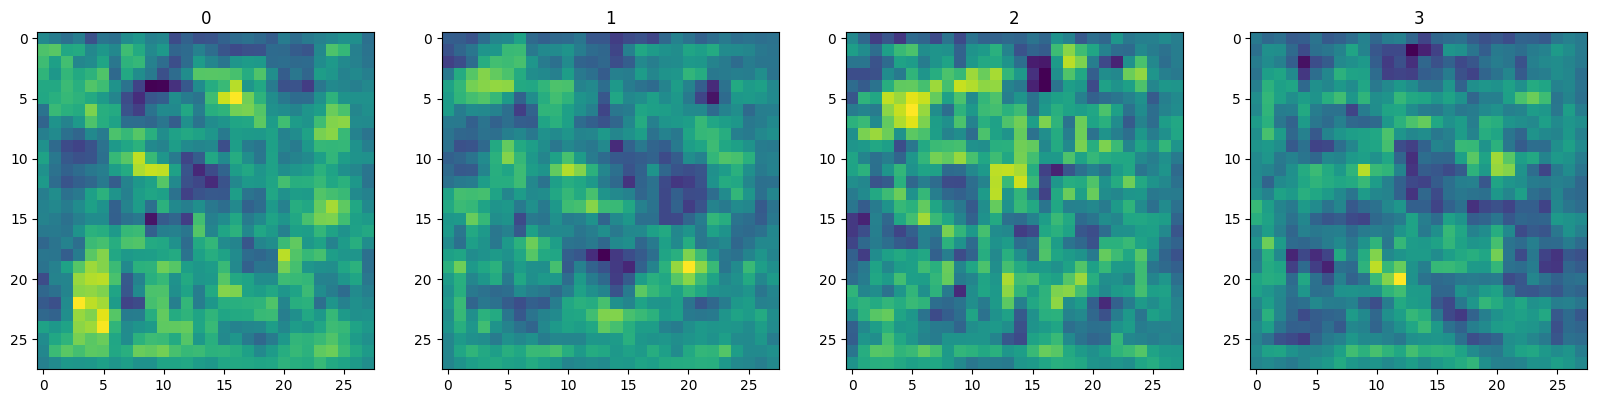

In [20]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

## 3.3 Build Discriminator

In [21]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [22]:
discriminator = build_discriminator()

In [23]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [24]:
img.shape

(28, 28, 1)

In [25]:
# Predict single image (28, 28, 1)
discriminator.predict(np.expand_dims(img,0))
# Predict multiple images (4, 28, 28, 1)
# discriminator.predict(img)

1/1 [==============================] - 0s 194ms/step


array([[0.4978016]], dtype=float32)

# 4. Construct Training Loop

## 4.1 Setup Losses and Optimizers

In [26]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [27]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## 4.2 Build Subclassed Model

In [28]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [29]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [30]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [31]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## 4.3 Build Callback

In [32]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [33]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## 4.3 Train

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=2000, callbacks=[ModelMonitor()])

Epoch 1/2000
469/469 [==============================] - 91s 184ms/step - d_loss: 0.4432 - g_loss: 1.2128
Epoch 2/2000
469/469 [==============================] - 86s 184ms/step - d_loss: 0.5876 - g_loss: 1.4305
Epoch 3/2000
469/469 [==============================] - 87s 186ms/step - d_loss: 0.6754 - g_loss: 0.6780
Epoch 4/2000
140/469 [=======>......................] - ETA: 1:02 - d_loss: 0.6910 - g_loss: 0.6019

## 4.4 Review Performance

In [120]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

# 5. Test Out the Generator

## 5.1 Generate Images

In [121]:
generator.load_weights('generator.h5')

ValueError: axes don't match array

In [65]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 16ms/step


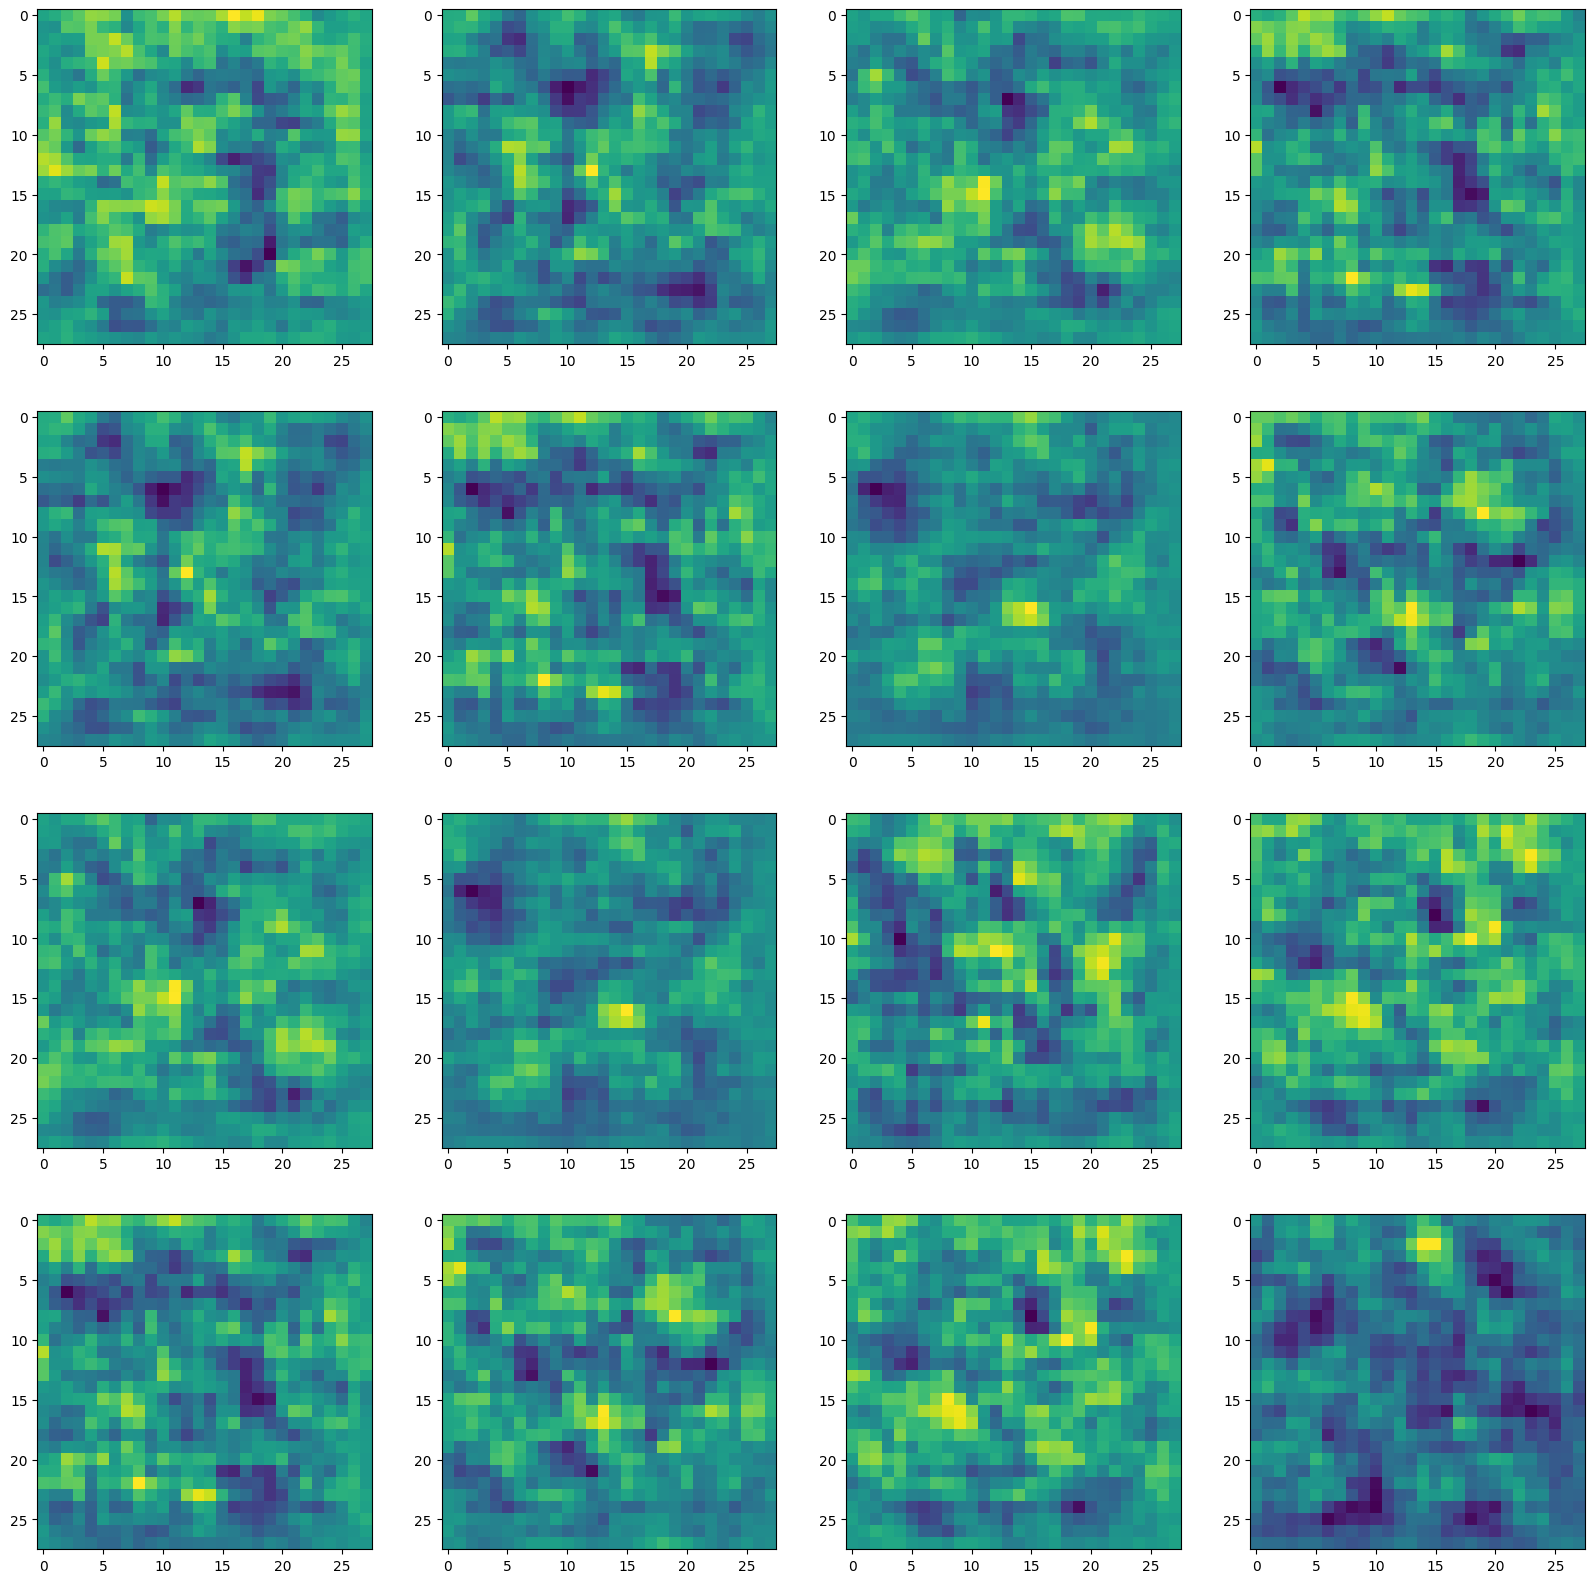

In [66]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

## Save the Model

In [63]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')